# 1. Notebook Setup

Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

import eda as eda

# 2. Loading and Prepare data

Load CSV

In [2]:
df = pd.read_csv("../data/Folsom_irradiance.csv", infer_datetime_format=True)
df

,timeStamp,ghi,dni,dhi
0,2014-01-02 08:00:00,0.0,0.0,0.0
1,2014-01-02 08:01:00,0.0,0.0,0.0
2,2014-01-02 08:02:00,0.0,0.0,0.0
3,2014-01-02 08:03:00,0.0,0.0,0.0
4,2014-01-02 08:04:00,0.0,0.0,0.0
...,...,...,...,...
1552315,2016-12-31 07:55:00,0.0,0.0,0.0
1552316,2016-12-31 07:56:00,0.0,0.0,0.0
1552317,2016-12-31 07:57:00,0.0,0.0,0.0
1552318,2016-12-31 07:58:00,0.0,0.0,0.0


Convert `timeStamp` to a datetime and set as index

In [3]:
df["timeStamp"] = pd.to_datetime(df["timeStamp"])
df = df.set_index('timeStamp')

Drop other columns (only GHI needed for ARIMA)

In [4]:
df = df["ghi"]

Split train/test

In [5]:
# Split data into train and test based on the years
train_start = "2014-01-01"
test_start = "2016-01-01"

train_data = df.loc[df.index < test_start]
test_data = df.loc[df.index >= test_start]

Ensure no data leakage

In [6]:
eda.print_df_index_date_range(train_data, "Train")
eda.print_df_index_date_range(test_data, "Test")

Train dataset date ranges = 2014-01-02 08:00:00 to 2015-12-31 07:59:00

Test dataset date ranges = 2016-01-01 08:00:00 to 2016-12-31 07:59:00



Check for missing values in ghi

In [7]:
assert df.isnull().any() == False

# for c in ["ghi", "dni", "dhi"]:
#     df[c]=df[c].fillna(method='ffill')

# 3. Train ARIMA Model

Set the frequency correctly by creating a new date range with a frequency of 'T' and then reindexing your data

In [8]:
# Create a new date range with frequency 'T'
date_range_train = pd.date_range(start=train_data.index[0], periods=len(train_data), freq='T')
date_range_test = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='T')

# Set the new date range as the index for the data
train_data.index = date_range_train
test_data.index = date_range_test

Fit ARIMA model (takes ~30 seconds)

In [9]:
model = ARIMA(train_data, order=(5, 1, 0))  # ARIMA print_df_index_date_range order
model_fit = model.fit()

In [10]:
# model = pm.auto_arima(train_data['ghi'], 
#                       m=12, 
#                       seasonal=True,
#                       start_p=0, 
#                       start_q=0, 
#                       max_order=4, 
#                       test='adf',
#                       error_action='ignore',  
#                       suppress_warnings=True,
#                       stepwise=True, 
#                       trace=True)

TODO: grid search to find best parameters

# 4. Make Forecasting Predictions

Loop through each minute prediction from 1 to 20, forecasts the next minute step using the ARIMA model, stores the forecasted values in a DataFrame, calculates the errors at each minute prediction, and plots the mean absolute error at each forecast horizon.

In [12]:
forecast_horizon = 20

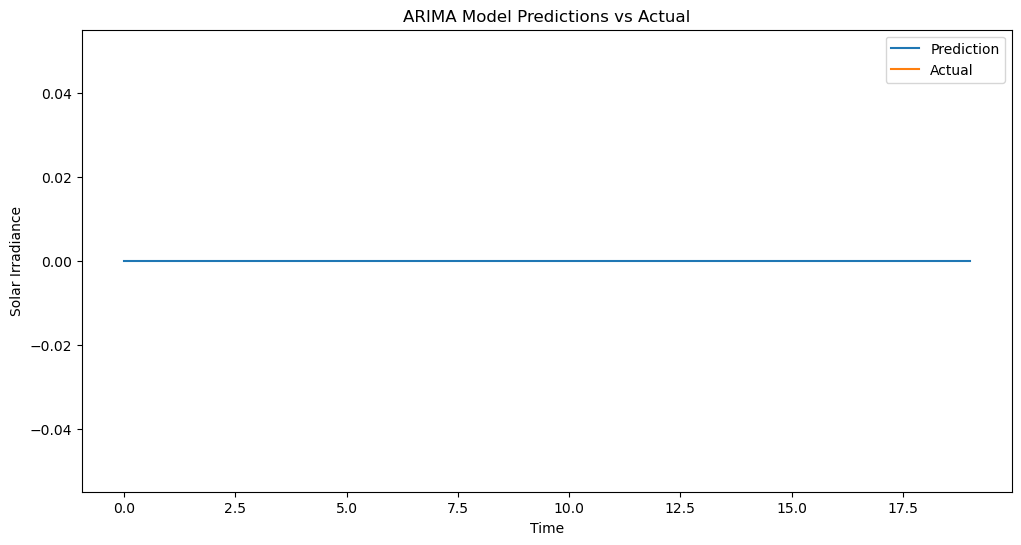

In [14]:
# Initialize an empty array to store forecasted values
forecast_values = []

# Break down the predictions into smaller chunks to manage memory
chunk_size = 10000
num_chunks = len(test_data) // chunk_size + 1

for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, len(test_data))
    chunk_forecast_series = model_fit.forecast(steps=(end_idx - start_idx) * forecast_horizon)
    chunk_forecast_array = np.array(chunk_forecast_series).reshape(-1, forecast_horizon)
    forecast_values.append(chunk_forecast_array)

# Concatenate the chunks to get the complete forecast values
forecast_values = np.concatenate(forecast_values)

# Create a DataFrame to store predictions
prediction_index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='T')
prediction_df = pd.DataFrame(data=forecast_values, index=prediction_index)

# Plot the predicted values for the first instance
plt.figure(figsize=(12, 6))
plt.plot(prediction_df.iloc[0], label='Prediction')
plt.plot(test_data.iloc[0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

In [15]:
prediction_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
2016-01-01 08:00:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322
2016-01-01 08:01:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322
2016-01-01 08:02:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322
2016-01-01 08:03:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322
2016-01-01 08:04:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29 07:55:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322
2016-12-29 07:56:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322
2016-12-29 07:57:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322
2016-12-29 07:58:00,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322,-7.509798e-322


___

In [ ]:
forecast_values = model_fit.forecast(steps=len(test_data) * FORECASTING_HORIZON).reshape(-1, FORECASTING_HORIZON)

In [ ]:
# Predict the entire forecast horizon for all instances
forecast_values = model_fit.forecast(steps=len(test_data) * FORECASTING_HORIZON).reshape(-1, FORECASTING_HORIZON)

# Create a DataFrame to store predictions
prediction_index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='T')
prediction_df = pd.DataFrame(data=forecast_values, index=prediction_index)

# Plot the predicted values for the first instance
plt.figure(figsize=(12, 6))
plt.plot(prediction_df.iloc[0], label='Prediction')
plt.plot(test_data.iloc[0], label='Actual')
plt.xlabel('Time')
plt.ylabel('Solar Irradiance')
plt.title('ARIMA Model Predictions vs Actual')
plt.legend()
plt.show()

Loop through each minute prediction from 1 to 20

In [22]:
len(test_data)

522720

In [ ]:
# Initialize an empty DataFrame to store forecasted values
forecast_values = np.empty((len(test_data), FORECASTING_HORIZON))

# Loop through each minute prediction from 1 to 20
for idx in range(len(test_data)):
    forecast = model_fit.forecast(steps=FORECASTING_HORIZON)
    forecast_values[idx, :] = forecast

Calculate and plot the errors at each minute prediction

In [27]:
errors = np.abs(forecast_values - test_data.values.reshape(-1, 1))
mean_errors = errors.mean(axis=0)

ValueError: Unable to coerce to DataFrame, shape must be (522720, 20): given (1568160, 1)

In [ ]:


plt.figure(figsize=(10, 6))
plt.plot(mean_errors, marker='o')
plt.xlabel('Forecast Horizon (Minutes)')
plt.ylabel('Mean Absolute Error')
plt.title('Mean Absolute Error at Each Forecast Horizon')
plt.xticks(range(1, FORECASTING_HORIZON + 1))
plt.grid(True)
plt.show()